In [21]:
from dataclasses import dataclass, field
from typing import Callable, List, Dict

import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
pd.options.plotting.backend = 'plotly'


@dataclass
class WalkforwardBacktester:
    """
    A basic Walkforward Backtester for comparing multiple strategies over a rolling
    lookback period and applying the best performing strategy to the next period.

    Attributes
    ----------
    pnl_df : pd.DataFrame
        DataFrame of PnL/returns for multiple strategies. Columns represent strategies,
        index is datetime.
    lookback_period : str
        Lookback period for evaluating strategy performance (e.g., '24M' for 24 months).
    rebalance_freq : str
        Frequency of rebalance (e.g., '3M' = every 3 months).
    score_func : Callable
        Function to score each strategy's performance on the lookback period. Defaults to Sharpe ratio.
    periods : List
        List of rebalance period start dates (filled during backtest run).
    lookback_start_skip_check : bool
        If True, allows lookback start to go before the start of available data.

    Example
    -------
    backtester = WalkforwardBacktester(
        pnl_df=pnl_strategies,
        lookback_period='24M',
        rebalance_freq='3M'
    )
    portfolio_pnl = backtester.run_backtest()
    """

    pnl_df: pd.DataFrame
    lookback_period: str
    rebalance_freq: str
    score_func: Callable[[pd.Series], float] = field(default=None)
    periods: List = None
    lookback_start_skip_check: bool = False
    rebalances: List[Dict[str, any]] = field(default_factory=list)

    def __post_init__(self):
        """Initialize default scoring function and empty portfolio series."""
        self.score_func = self.score_func or self._sharpe_ratio
        self.portfolio_pnl = pd.Series(index=self.pnl_df.index, dtype=np.float64)

    def _sharpe_ratio(self, returns: pd.Series) -> float:
        """Default scoring function: Sharpe ratio."""
        return returns.mean() / returns.std() if returns.std() != 0 else 0

    def _select_best_strategy(self, lookback_df: pd.DataFrame) -> str:
        """
        Evaluate all strategies in the lookback period and select the one with highest score.

        Returns
        -------
        best_strategy : str
            Name of the strategy with the best score
        strategy_scores : pd.Series
            Scores for all strategies
        """
        strategy_scores = lookback_df.apply(self.score_func)
        return strategy_scores.idxmax(), strategy_scores

    def run_backtest(self) -> pd.Series:
        """
        Run the walkforward backtest. At each rebalance period, select the best strategy
        based on the lookback period and apply it forward.

        Returns
        -------
        portfolio_pnl : pd.Series
            Series of portfolio returns following the walkforward strategy.
        """
        # Ensure rebalance and lookback frequencies are in months
        assert self.rebalance_freq[-1] == "M", "rebalance freq must be in months (M)"
        assert self.lookback_period[-1] == "M", "lookback period must be in months (M)"

        # Create rebalance period start dates
        self.periods = pd.date_range(
            start=self.pnl_df.index[0],
            end=self.pnl_df.index[-1] + relativedelta(months=int(self.rebalance_freq[:-1])),
            freq=self.rebalance_freq
        )

        # Loop over rebalance periods
        for start_date, end_date in zip(self.periods[:-1], self.periods[1:]):
            # Lookback period ends 1 day before rebalance start
            lookback_end = start_date - pd.Timedelta(days=1)
            lookback_start = lookback_end - relativedelta(months=int(self.lookback_period[:-1]))

            # Skip if lookback starts before available data
            if (lookback_start < self.pnl_df.index[0]) and (not self.lookback_start_skip_check):
                continue

            lookback_df = self.pnl_df.loc[lookback_start:lookback_end]
            best_strat, strategy_scores = self._select_best_strategy(lookback_df)

            # Store details for analysis
            self.rebalances.append({
                'start_date': start_date,
                'end_date': end_date,
                'lookback_start': lookback_start,
                'lookback_end': lookback_end,
                'best_strategy': best_strat,
                'strategy_scores': strategy_scores,
                'lookback_df': lookback_df,
                'selected_strategy_mean_returns': self.pnl_df[best_strat].loc[start_date:end_date].mean(),
                'selected_strategy_mean_std': self.pnl_df[best_strat].loc[start_date:end_date].std()
            })

            # Apply the selected strategy's returns to portfolio
            self.portfolio_pnl.loc[start_date:end_date] = self.pnl_df[best_strat].loc[start_date:end_date]

        return self.portfolio_pnl

    def get_rebalance_details(self) -> pd.DataFrame:
        """Return DataFrame of rebalance period decisions and metrics."""
        return pd.DataFrame(self.rebalances)




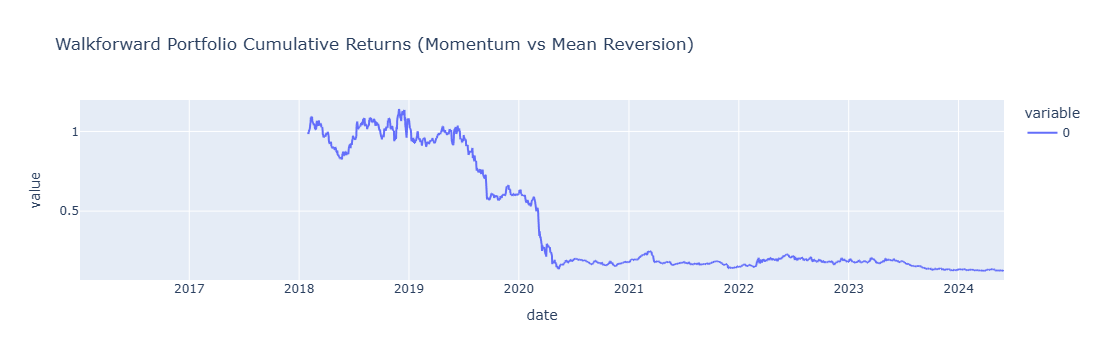

In [24]:
"""
NOTE:
This is a very basic draft strategy for illustrative purposes. This Strategy goes long or short based on the current strat selection - momentum or 
mean reversion and last n days return. 
- The walkforward backtester evaluates multiple strategies over a rolling lookback period.
- At each rebalance, the best performing strategy (based on Sharpe ratio by default) is applied forward.
- The strategy here (simple momentum vs mean reversion with fixed lookbacks) performs poorly as can be seen in performance charts for walfforward
- Goal: use this framework to design a more robust strategy with better walkforward performance.
"""


# -------------------------------
# Example Usage: Brent Index
# -------------------------------
df = pd.read_excel(r"brent_index.xlsx", parse_dates=['date'], index_col='date')
rets = df['CO1 Comdty'].pct_change()
tcost = 0.00015  # Transaction cost per trade

# ------------------------------- # Define multiple strategies # ----------
lookback_days = [2, 4, 8, 16, 32, 64, 128, 256] 
pnl_strategies = pd.DataFrame(index=rets.index) 
for m in lookback_days: #rolling returns till yesterday, Shift(1) below to remove look ahead bias 
    rolling_ret = (1 + rets).rolling(window=m).apply(np.prod, raw=True).shift(1) - 1 
    
    # Momentum: go long if past return > 0, else short 
    momentum_signal = pd.Series(np.where(rolling_ret > 0, 1, -1), index=rets.index) 
    pnl_strategies[f"{m}D_momentum"] = momentum_signal * rets - tcost * abs(momentum_signal.diff()) 
    
    # Mean Reversion: go short if past return > 0, else long 
    meanrev_signal = pd.Series(np.where(rolling_ret > 0, -1, 1), index=rets.index) 
    pnl_strategies[f"{m}D_meanrev"] = meanrev_signal * rets - tcost * abs(meanrev_signal.diff())
    
# -------------------------------
# Run Walkforward Backtest
# -------------------------------
backtester = WalkforwardBacktester(
    pnl_df=pnl_strategies,
    lookback_period='24M',
    rebalance_freq='3M'
)

portfolio_pnl = backtester.run_backtest()

# -------------------------------
# Inspect Rebalance Decisions
# -------------------------------
rebalance_details = backtester.get_rebalance_details()

# -------------------------------
# Portfolio Performance
# -------------------------------
portfolio_cum = (1 + portfolio_pnl).cumprod()
portfolio_cum.plot(title="Walkforward Portfolio Cumulative Returns (Momentum vs Mean Reversion)")

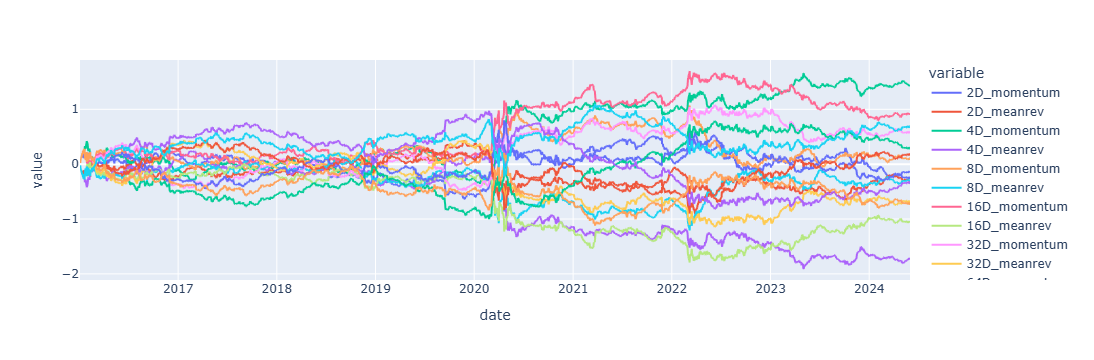

In [25]:
pnl_strategies.cumsum().plot()

In [8]:
rebalance_details

,start_date,end_date,lookback_start,lookback_end,best_strategy,strategy_scores,lookback_df,selected_strategy_mean_returns,selected_strategy_mean_std
0,2020-01-31,2020-04-30,2016-01-30,2020-01-30,128W_meanrev,2W_momentum -0.034201 2W_meanrev 0.0...,2W_momentum 2W_meanrev 4W_moment...,-0.010662,0.072655
1,2020-04-30,2020-07-31,2016-04-29,2020-04-29,16W_momentum,2W_momentum -0.001428 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,0.000262,0.034104
2,2020-07-31,2020-10-31,2016-07-30,2020-07-30,4W_momentum,2W_momentum 0.002205 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,-0.000278,0.022011
3,2020-10-31,2021-01-31,2016-10-30,2020-10-30,16W_momentum,2W_momentum -0.002620 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,0.000965,0.019455
4,2021-01-31,2021-04-30,2017-01-30,2021-01-30,4W_momentum,2W_momentum 8.435922e-07 2W_meanrev ...,2W_momentum 2W_meanrev 4W_moment...,0.000797,0.023268
5,2021-04-30,2021-07-31,2017-04-29,2021-04-29,4W_momentum,2W_momentum 0.002411 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,-0.000387,0.017065
6,2021-07-31,2021-10-31,2017-07-30,2021-07-30,4W_momentum,2W_momentum 0.000516 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,0.001182,0.016286
7,2021-10-31,2022-01-31,2017-10-30,2021-10-30,4W_momentum,2W_momentum 0.000473 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,-0.001940,0.023392
8,2022-01-31,2022-04-30,2018-01-30,2022-01-30,16W_momentum,2W_momentum 0.006901 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,0.003637,0.039128
9,2022-04-30,2022-07-31,2018-04-29,2022-04-29,16W_momentum,2W_momentum 0.009931 2W_meanrev -0.0...,2W_momentum 2W_meanrev 4W_moment...,0.001586,0.027135
